In [93]:
%run excute_nonZS_MaxMin.ipynb
%matplotlib inline
import csv
import statsmodels.api as sm
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

## 1. Functions

In [96]:
#if I use this, then the result will not be correct - just logics outside of the function

def network_data(s, G, n):
    (v1, v2, max_opinion, min_opinion, max_pol) = MaxMin_play(s, n, G)
    (scaled_deg_cent, scaled_clo_cent, scaled_eigen_cent, scaled_MinPaths_sort, scaled_op_extre, scaled_cc) = metrics(G, v1)
    # print(v1, max_opinion)
    #print("actual_ranks INPUT:",s, n, v1, max_opinion )
    (actual_Y_dict, actual_ranks, innate_por_dict) = actual_rank(s, n, v1, max_opinion)
    keys = converted_dict2.keys()
    df = pd.DataFrame({'keys': list(keys),
                   'x1_d': [sorted_gap[x] for x in keys],
                   'x2_deg':[converted_dict[x] for x in keys],
                   'x3_clo':[converted_dict1[x] for x in keys],
                   'x4_eigen': [converted_dict2[x] for x in keys],
                   'x5_path': [scaled_MinPaths_sort[x] for x in keys],
                   'x6_cc': [scaled_cc[x] for x in keys],
                   'y_value': [actual_Y_dict[x] for x in keys],
                    'ranks_y':[actual_ranks[x] for x in keys]})

    print("_________________")
    a = sorted(actual_Y_dict.items(), key=lambda x:x[1])
#     print(a)
    if a[0][0]!= v1:
        print(a[0][0]==v2)
    else:
        print(a[1][0]==v2)
    
    return (df, actual_Y_dict, innate_por_dict)

In [136]:
# x_values Normalizaion 
from sklearn.preprocessing import MinMaxScaler
def rescale(dic): # input x is a dictionary - sorted node index: value
    minmax_scale = MinMaxScaler(feature_range=(0, 1))
    x = list(dic.values())
    x = np.array(x)
    x = x.reshape(-1, 1)
    x_scale = minmax_scale.fit_transform(x).flatten()
    dic_scale = dict(zip(dic.keys(),x_scale))
    return dic_scale  # output

# Creat Metrics for Regression

################### create shortest path from all nodes to max selected node v1 ############
def shortest_pth(G, v1):
    nxG = nx.from_numpy_matrix(G)  
    paths = nx.single_source_shortest_path(nxG, v1) 
    # the length of shortest path from v2 to v1
    lenths =[]
    for v in paths.items():
        lenth = len(v[1])
        lenths.append(lenth)  
    PathLen = dict(zip(paths.keys(),lenths))
    #print("path_lenth",PathLen)
    return PathLen

def local_clustering_coefficient(G):
    clus_coef = []
    for node in range(len(G)):
        neighbors = np.nonzero(G[node])[1]
        num_neighbors = len(neighbors)
        if num_neighbors < 2:
            clustering_coefficient = 0.0  # No triangles possible
        else:
            num_triangles = 0
            for i in range(num_neighbors - 1):
                for j in range(i + 1, num_neighbors):
                    #print(neighbors[i], neighbors[i])
                    if G[neighbors[i], neighbors[j]] == 1:
                        num_triangles = num_triangles + 1
                        #print(num_triangles)
#             print("num_triangles:",num_triangles)
            clustering_coefficient = (2.0 * num_triangles) / (num_neighbors * (num_neighbors - 1))
        clus_coef.append((node, clustering_coefficient))
    cc = dict(clus_coef)
    
    return cc


def metrics(G, v1):

    nxG = nx.from_numpy_matrix(G) 
    # G = nx.karate_club_graph()
   # print("_______________Degree Centrality_____________________________")  
    deg_centrality = nx.degree_centrality(nxG)
    sortedDict = sorted(deg_centrality.items(), key=lambda x:x[1])
    converted_dict = dict(sortedDict)
    # print(converted_dict)
    #print("                           ")
   # print("_______________Closeness Rank_____________________________")
    close_centrality = nx.closeness_centrality(nxG)
    sortedDict1 = sorted(close_centrality.items(), key=lambda x:x[1])
    converted_dict1 = dict(sortedDict1)
    # print(converted_dict1)
    #print("                           ")
   # print("_______________Page Rank_____________________________")
    pr = nx.eigenvector_centrality(nxG)
    sortedDict2 = sorted(pr.items(), key=lambda x:x[1])
    converted_dict2 = dict(sortedDict2)
    # print(converted_dict2)
    #print("                           ")
   # print("_______________Opinion Extremity_____________________________")
    def gap(op, n):
        ones = np.ones((n, 1))
        x = op - (np.dot(np.transpose(op),ones)/n) * ones
        return abs(x)
    gap = gap(s,n)
    my_gap = {index: value for index, value in enumerate(gap)}
    sorting_gap = sorted(my_gap.items(), key=lambda x:x[1], reverse=True)
    sorted_gap = dict(sorting_gap)
    # print("opinion - mean")
    # print(sorted_gap)
    
   # print("________________Shortest Path_____________________________")
    PathLen = shortest_pth(G, v1)
    # creat a dict node:shortest length to v1(max selected node)
    
   #print("________________cluster coefficient____________________________") 
    cc = local_clustering_coefficient(G)
    
#     PathLen = rescale(PathLen) # rescale the shortest path to the range (0,1) for regression
#     converted_dict= rescale(converted_dict)
#     converted_dict1 = rescale(converted_dict1)
#     converted_dict2 = rescale(converted_dict2)
#     sorted_gap = rescale(sorted_gap)
#     cc = rescale(cc)
    
    # sorting all varibles based on the node index
    scaled_MinPaths_sort = dict(sorted(PathLen.items(), key=lambda x:x[0]))
    #print("scaled_paths_sort",scaled_MinPaths_sort)
    
    scaled_deg_cent = dict(sorted(converted_dict.items(), key=lambda x:x[0]))
    scaled_clo_cent = dict(sorted(converted_dict1.items(), key=lambda x:x[0]))
    scaled_eigen_cent = dict(sorted(converted_dict2.items(), key=lambda x:x[0]))
    scaled_op_extre = dict(sorted(sorted_gap.items(), key=lambda x:x[0]))
    scaled_cc = dict(sorted(cc.items(), key=lambda x:x[0]))
    
    return (scaled_deg_cent, scaled_clo_cent, scaled_eigen_cent, scaled_MinPaths_sort, scaled_op_extre, scaled_cc)

    


In [140]:
# Find the ground truth of Min's action - knowing Max chooses v1, what Min's action will be?
def actual_rank(s, n, v1, max_opinion):

    L = scipy.sparse.csgraph.laplacian(G, normed=False)  # Return the Laplacian matrix
    A = np.linalg.inv(np.identity(n) + L)  # A = (I + L)^(-1)\n  Stanford paper theory
    op = copy.copy(s)
    op[v1] = max_opinion
    
    all_1 = list(range(n))    # for all agent 
    C1 = [x for x in all_1 if x != v1]  # for the vertice that Maximizer has not touched
    innat_por = obj_polarization(A, s, n) # Calculate the polarization after maximzer' action - not innate polarization
    max_por = obj_polarization(A, op, n)
    results = []
    real_por1 = []
    for v2 in C1:   
        (changed_opinion, por) = derivate_s(op,n,v2,A)   # find the best new_op option  
        por_1 = por - max_por     # append the change of the polarization
        results.append((v2, por_1))
        real_por1.append((v2,innat_por))
#         print("innate_por ",real_por1)
    results.append((v1,0)) # minimizer cannot choose v1, but we need all nodes for the dataframe
    real_por1.append((v1,innat_por))

    innate_por_dict = dict(real_por1)
#     actual_por_dict = dict(sorted(actual_por.items(), key=lambda x:x[0]))  
    
    actual_Y = dict(results) # now we have - node:polarization
    # most of v are in sequential order, but v1 might not be in order, so we need to sort it
    actual_Y_dict = dict(sorted(actual_Y.items(), key=lambda x:x[0]))   #sort - list nodes in sequential of the node index
    actual_Y_dict_scale = rescale(actual_Y_dict)
   # dictionary -  node:polarization
   # print("actual_Y_dict",actual_Y_dict) 

    # create the rank of the Y values based on minimizer's choice 
    actual_Y_order = dict(sorted(actual_Y.items(), key=lambda x:x[1]))  #sort - list nodes in sequential of the polariz.
    node_ranks= dict(zip(actual_Y_order.keys(), all_1)) # dictionary -  node:polarization rank(replace polarz. with rank)
    actual_ranks = dict(sorted(node_ranks.items(), key=lambda x:x[0])) # sort - list node in sequential node index
    
    return (actual_Y_dict_scale, actual_ranks, innate_por_dict)  # return two dictionary, 1. sequential node: polarization, 
                                                                # 2. seq. node: pol rank

In [141]:
s = make_innat_opinions(n)
G = make_random_network(n)
nxG = nx.from_numpy_matrix(G) 

v1 = 1
max_opinon=0

a = actual_rank(s, n, v1, max_opinion)

L = scipy.sparse.csgraph.laplacian(G, normed=False)  # Return the Laplacian matrix
A = np.linalg.inv(np.identity(n) + L)  # A = (I + L)^(-1)\n  Stanford paper theory
op = copy.copy(s)
op[v1] = max_opinion

all_1 = list(range(n))    # for all agent 
C1 = [x for x in all_1 if x != v1]  # for the vertice that Maximizer has not touched
innat_por = obj_polarization(A, s, n) # Calculate the polarization after maximzer' action - not innate polarization
max_por = obj_polarization(A, op, n)
results = []
real_por1 = []
for v2 in C1:   
    (changed_opinion, por) = derivate_s(op,n,v2,A)   # find the best new_op option  
    por_1 = por - max_por     # append the change of the polarization
    results.append((v2, por_1))
    real_por1.append((v2,innat_por))
results.append((v1,0)) # minimizer cannot choose v1, but we need all nodes for the dataframe
real_por1.append((v1,innat_por))

innate_por_dict = dict(real_por1)
#     actual_por_dict = dict(sorted(actual_por.items(), key=lambda x:x[0]))  

actual_Y = dict(results) # now we have - node:polarization
# most of v are in sequential order, but v1 might not be in order, so we need to sort it
actual_Y_dict = dict(sorted(actual_Y.items(), key=lambda x:x[0]))   #sort - list nodes in sequential of the node index
actual_Y_dict_scale = rescale(actual_Y_dict)
# dictionary -  node:polarization
# print("actual_Y_dict",actual_Y_dict) 

# create the rank of the Y values based on minimizer's choice 
actual_Y_order = dict(sorted(actual_Y.items(), key=lambda x:x[1]))  #sort - list nodes in sequential of the polariz.
node_ranks= dict(zip(actual_Y_order.keys(), all_1)) # dictionary -  node:polarization rank(replace polarz. with rank)
actual_ranks = dict(sorted(node_ranks.items(), key=lambda x:x[0])) # sort - list node in sequential node index

print(innate_por_dict)

{0: 0.0199012084611508, 2: 0.0199012084611508, 3: 0.0199012084611508, 4: 0.0199012084611508, 5: 0.0199012084611508, 6: 0.0199012084611508, 7: 0.0199012084611508, 8: 0.0199012084611508, 9: 0.0199012084611508, 10: 0.0199012084611508, 11: 0.0199012084611508, 12: 0.0199012084611508, 13: 0.0199012084611508, 14: 0.0199012084611508, 15: 0.0199012084611508, 16: 0.0199012084611508, 17: 0.0199012084611508, 18: 0.0199012084611508, 19: 0.0199012084611508, 20: 0.0199012084611508, 21: 0.0199012084611508, 22: 0.0199012084611508, 23: 0.0199012084611508, 24: 0.0199012084611508, 25: 0.0199012084611508, 26: 0.0199012084611508, 27: 0.0199012084611508, 28: 0.0199012084611508, 29: 0.0199012084611508, 1: 0.0199012084611508}


# Creat Dataset

In [149]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Initialize an empty DataFrame to store your data
df = pd.DataFrame()

# Initialize empty lists to store data for training and testing
train_data1 = []
valid_data1 =[]
test_data1 = []
Game_result = []
sets = 50
for i in range(1, sets):  # Change the range if you want more iterations
    # Your existing code here to generate data for each iteration
    s = make_innat_opinions(n)
    G = make_random_network(n)
    (v1, v2, max_opinion, min_opinion, max_pol) = MaxMin_play(s, n, G)
    Game_result.append((v2,max_pol))
    (deg_cent, clo_cent, eigen_cent, MinPaths_sort,op_extre, cc) = metrics(G, v1)
   # (converted_dict, converted_dict1, converted_dict2, sorted_gap, scaled_MinPaths_sort) = metrics(G, v1)
    
    # Calculate actual ranks and rescale polarization change
    (actual_Y_dict, actual_ranks, innate_por_dict) = actual_rank(s, n, v1, max_opinion)
    # rescale
    scaled_actual_Y_dict = rescale(actual_Y_dict)
    
    keys = list(eigen_cent.keys())
    # Assuming you have generated 'temp_df' as you did in your original code
    temp_df = pd.DataFrame(({'keys': list(keys),
                       'x1_d': [op_extre[x][0] for x in keys],
                       'x2_deg':[deg_cent[x] for x in keys],
                       'x3_clo':[clo_cent[x] for x in keys],
                       'x4_eigen': [eigen_cent[x] for x in keys],
                       'x5_path': [MinPaths_sort[x] for x in keys],
                       'x6_cc': [cc[x] for x in keys],
                       'x7_po':[innate_por_dict[x] for x in keys],
                       'y_value': [scaled_actual_Y_dict[x] for x in keys],
                        'ranks_y':[actual_ranks[x] for x in keys]}))

    # Append the temporary DataFrame to the main DataFrame
    df = pd.concat([df, temp_df], ignore_index=True)

    # Append the data to either the training or testing list
    if i <= 0.8*sets:  # Use first 80% for trainning, adjust as needed
        train_data1.append(temp_df)
    elif i> 0.8*sets and i <= 0.9*sets:
        valid_data1.append(temp_df)
    else:
        test_data1.append(temp_df)


                                
Maximizer finds its target agent:
Max Action:    Agent29 's opinion 0.8271169432403425 changed to 1
Min Action:    Agent28 's opinion 0.9818570498263892 changed to 0.38568203917047145
Network reaches equilibrium Polarization: 0.026435826468651332
                                
Maximizer finds its target agent:
Max Action:    Agent28 's opinion 0.6727456898053966 changed to 0
Min Action:    Agent27 's opinion 0.11148210456842333 changed to 0.606635519330606
Network reaches equilibrium Polarization: 0.014654617855643804
                                
Maximizer finds its target agent:
Max Action:    Agent29 's opinion 0.3329377219702512 changed to 0
Min Action:    Agent25 's opinion 0.9098407479814604 changed to 0.39465692424743093
Network reaches equilibrium Polarization: 0.03378731944590402
                                
Maximizer finds its target agent:
Max Action:    Agent26 's opinion 0.6470613674816937 changed to 0
Min Action:    Agent28 's opi

KeyError: 0

In [150]:
print(train_data1)

[    keys      x1_d    x2_deg    x3_clo  x4_eigen  x5_path     x6_cc     x7_po  \
0      0  0.409759  0.586207  0.707317  0.213151        3  0.602941  0.022199   
1      1  0.091998  0.551724  0.690476  0.208540        3  0.700000  0.022199   
2      2  0.049089  0.482759  0.659091  0.175780        3  0.615385  0.022199   
3      3  0.086069  0.482759  0.644444  0.179630        3  0.648352  0.022199   
4      4  0.241757  0.482759  0.659091  0.179451        3  0.626374  0.022199   
5      5  0.382713  0.586207  0.707317  0.202908        2  0.551471  0.022199   
6      6  0.405771  0.586207  0.707317  0.218452        3  0.676471  0.022199   
7      7  0.189462  0.551724  0.690476  0.197418        3  0.583333  0.022199   
8      8  0.396780  0.655172  0.743590  0.232277        3  0.573099  0.022199   
9      9  0.087578  0.551724  0.690476  0.213541        3  0.750000  0.022199   
10    10  0.187189  0.551724  0.690476  0.200341        3  0.566667  0.022199   
11    11  0.162554  0.51724

In [153]:
#df.to_excel(r'C:/Users/xzhan/OneDrive/Misinfo Paper/One Node - Final/NE Prediction/Network_datasets.xlsx', index=False)
# Concatenate the training and testing dataframes
train_df = pd.concat(train_data1, ignore_index=True)
# test_df = pd.concat(test_data, ignore_index=True)
# valid_df = pd.concat(valid_data, ignore_index=True)
#Split the data into features (X) and target (Y)
X_train = train_df[['x1_d', 'x2_deg', 'x3_clo', 'x4_eigen','x5_path','x6_cc','x7_po','y_value']].values
Y_train = train_df['y_value'].values
Y_ranks = train_df['ranks_y'].values

# X_test = test_df[['x1_d', 'x2_deg', 'x3_clo', 'x4_eigen','x5_path','x6_cc','x7_po','y_value']].values
# Y_test = test_df['y_value'].values
# Y_test_ranks = test_df['ranks_y'].values

# X_valid = valid_df[['x1_d', 'x2_deg', 'x3_clo', 'x4_eigen','x5_path','x6_cc','x7_po','y_value']].values
# Y_valid = valid_df['y_value'].values
# Y_vaid_ranks = valid_df['ranks_y'].values


# # # #########################################################
X_train = train_df[['x1_d', 'x4_eigen','x5_path','x6_cc','y_value']].values
# Y_train = train_df['y_value'].values
# Y_ranks = train_df['ranks_y'].values

# X_test = test_df[['x11', 'x22', 'x33']].values
# Y_test = test_df['y_value'].values
# X_valid = valid_df[['x11', 'x22', 'x33']].values
# Y_valid = valid_df['y_value'].values


# ######################################################
# X_train = train_df[['x11', 'x22']].values
# Y_train = train_df['y_value'].values
# X_test = test_df[['x11', 'x22']].values
# Y_test = test_df['y_value'].values
# X_valid = valid_df[['x11', 'x22']].values
# Y_valid = valid_df['y_value'].values

########################################################
# X_train = train_df[['x22']].values
# Y_train = train_df['y_value'].values
# X_test = test_df[['x22']].values
# Y_test = test_df['y_value'].values
# X_valid = valid_df[['x22']].values
# Y_valid = valid_df['y_value'].values

# A. Linear Regression Prediction

In [154]:

# add a constant term to the dataframe
X_train_OLS = sm.add_constant(X_train)
# fit the linear regression model
model_OLS = sm.OLS(Y_train,X_train_OLS).fit()
#model = sm.OLS(df['y_rank'], df[['const', 'x1','x2','x3']]).fit()
# print the model summary
print(model_OLS.summary())

############## Model Evaluation#################
coefficients = model_OLS.params
standard_errors = model_OLS.bse
print("coefficients:",coefficients)
print("standard_errors:",standard_errors)
r_squared = model_OLS.rsquared
from sklearn.metrics import mean_squared_error

# Calculate Mean Squared Error (MSE)
predictions_ols = model_OLS.predict(X_train_OLS)
mse_ols = mean_squared_error(Y_train, predictions_ols)
print(f"Mean Squared Error: {mse_ols}")
residuals_ols = model_OLS.resid
p_values_ols = model_OLS.pvalues
print(f"P value:{p_values_ols}")
f_statistic = model_OLS.fvalue
print(f"F-test:{f_statistic}")


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.337e+29
Date:                Fri, 10 Nov 2023   Prob (F-statistic):               0.00
Time:                        17:32:11   Log-Likelihood:                 14551.
No. Observations:                 450   AIC:                        -2.908e+04
Df Residuals:                     441   BIC:                        -2.905e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.22e-16   4.41e-15      0.050      0.9

In [106]:
#### pred_Y = model.predict(df[['const', 'x11','x22','x33']])
# add a constant term to the dataframe
X_test_OLS = sm.add_constant(X_test)
predictions_test_ols = model_OLS.predict(X_test_OLS)
#print(predictions_test_ols)
# Calculate Mean Squared Error (MSE)
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(Y_test, predictions_test_ols)
mae = mean_absolute_error(Y_test, predictions_test_ols)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
residuals_ols = model_OLS.resid
p_values_ols = model_OLS.pvalues
print(f"P value:{p_values_ols}")
f_statistic = model_OLS.fvalue
print(f"F-test:{f_statistic}")


# pred_index = np.argmin(pred_Y)
# Find k nodes index with smallest polarization - use to predict minimizer's choice
k = 3
print(predictions_ols.argsort()[:k])

Mean Squared Error (MSE): 0.0790
Mean Absolute Error (MAE): 0.2290
P value:[1.293e-265 7.795e-021 9.463e-005 4.979e-013 2.620e-014]
F-test:46.77953472334489
[834 812 837]


# B. Neural Network Prediction

Epoch 1/50
75/75 - 0s - loss: 42.5968 - mae: 5.9613
Epoch 2/50
75/75 - 0s - loss: 12.0865 - mae: 2.8943
Epoch 3/50
75/75 - 0s - loss: 9.3134 - mae: 2.4982
Epoch 4/50
75/75 - 0s - loss: 8.7329 - mae: 2.4159
Epoch 5/50
75/75 - 0s - loss: 8.3596 - mae: 2.3544
Epoch 6/50
75/75 - 0s - loss: 8.0048 - mae: 2.2871
Epoch 7/50
75/75 - 0s - loss: 7.7561 - mae: 2.2638
Epoch 8/50
75/75 - 0s - loss: 7.5553 - mae: 2.2283
Epoch 9/50
75/75 - 0s - loss: 7.3919 - mae: 2.1965
Epoch 10/50
75/75 - 0s - loss: 7.2790 - mae: 2.1854
Epoch 11/50
75/75 - 0s - loss: 7.1517 - mae: 2.1687
Epoch 12/50
75/75 - 0s - loss: 7.0626 - mae: 2.1476
Epoch 13/50
75/75 - 0s - loss: 6.9957 - mae: 2.1354
Epoch 14/50
75/75 - 0s - loss: 6.9360 - mae: 2.1223
Epoch 15/50
75/75 - 0s - loss: 6.9007 - mae: 2.1206
Epoch 16/50
75/75 - 0s - loss: 6.8565 - mae: 2.1112
Epoch 17/50
75/75 - 0s - loss: 6.8305 - mae: 2.1077
Epoch 18/50
75/75 - 0s - loss: 6.7885 - mae: 2.0966
Epoch 19/50
75/75 - 0s - loss: 6.7497 - mae: 2.0889
Epoch 20/50
75/75 -

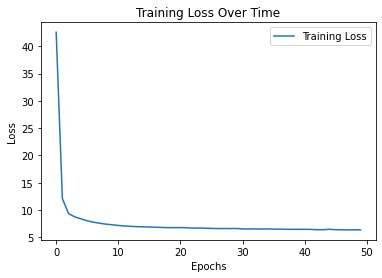

In [69]:
# Standardize the features (important for neural networks)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_valid = scaler.transform(X_valid)
# Define a simple neural network model
model_NN = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)  # Output layer with a single neuron (for regression)
])

# Compile the model
model_NN.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model_NN.fit(X_train, Y_train, epochs=50, batch_size=32, verbose=2)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss Over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
print(X_test.shape)
# Use the trained model to make predictions on the test data
predictions = model_NN.predict(X_test)
# # Print the predictions
# for i, pred in enumerate(predictions):
#     print(f"Prediction for sample {i+1}: {pred[0]}")

x = 2
index = int(sets*0.9+1+x)

print(Game_result[index])

predictions_1net = predictions[x*n:(x+1)*n]
indexed_dict = {}
for index, item in enumerate(predictions_1net):
    indexed_dict[index] = item[0]

print(sorted(indexed_dict.items(), key=lambda x:x[1]))

(300, 4)
(28, 0.04187373571282055)
[(16, -0.0151415095), (10, -0.015009886), (5, -0.014558872), (4, -0.011456942), (8, -0.011417782), (19, -0.011154255), (1, -0.010690497), (3, -0.009535773), (22, -0.008449068), (24, -0.008164829), (13, -0.008027699), (18, -0.0075722393), (20, -0.0070563536), (26, -0.006835861), (9, -0.0066093635), (0, -0.006463727), (25, -0.0061844494), (23, -0.004704898), (17, -0.0032228364), (21, -0.0027107021), (29, -0.0012028946), (14, -0.00038064294), (15, 0.0008013414), (12, 0.0011436099), (7, 0.001608269), (2, 0.0020497625), (28, 0.0020708197), (11, 0.0037495808), (27, 0.0077538732), (6, 0.012119165)]


### NN Model Evaluation

In [70]:
# Get the weights and biases of the neural network
weights = model_NN.get_weights()

# Print the weights and biases
for layer_num, layer_weights in enumerate(weights):
    print(f"Layer {layer_num} Weights:")
    print(layer_weights.shape)
   
# Evaluate the model on the test data
loss, mae = model_NN.evaluate(X_test, Y_test)
# # Print the Mean Absolute Error
# print(f"Mean Absolute Error on Test Data: {mae}")
# Use the trained model to make predictions on the test data
predictions = model_NN.predict(X_test)

# Calculate Mean Absolute Error (MAE) manually
mae = np.mean(np.abs(predictions - Y_test))
print(f"Mean Absolute Error on Test Data: {mae}")
print(f"Mean Absolute Error percentage on Test Data: {mae/np.mean(Y_test)}")
# Calculate MSE
mse = mean_squared_error(Y_test, predictions)
print(f"Mean Squared Error: {mse}")
# Calculate R-squared score
r2 = r2_score(Y_test, predictions)
print(f"R-squared (R^2) Score: {r2}")

Layer 0 Weights:
(4, 64)
Layer 1 Weights:
(64,)
Layer 2 Weights:
(64, 32)
Layer 3 Weights:
(32,)
Layer 4 Weights:
(32, 1)
Layer 5 Weights:
(1,)


## C. Decision Tree Prediction

In [107]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Create a label encoder to map the unique values to integers
label_encoder = LabelEncoder()

# Encode the original target variable into integers
encoded_y = label_encoder.fit_transform()
print(encoded_y)
# Split the encoded values into batches (30 unique values in each batch)
batch_size = n
batched_y = np.floor(encoded_y / batch_size).astype(int)
print(batched_y)
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, batched_y)  # Train the model

# Decode the predicted values
predicted_batched_y = decision_tree.predict(X_test)
predicted_y = predicted_batched_y * batch_size  # Decode the batched predictions


[ 416  256  573 ...  556 1974 2242]
[13  8 19 ... 18 65 74]


## Sample eg - unit test

In [127]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

# Assume you have the necessary functions defined: make_innat_opinions, make_random_network, network_data,
# MaxMin_play, metrics, actual_rank, and rescale

# Initialize an empty DataFrame
df = pd.DataFrame()

# Define the number of iterations
num_iterations = 50  # Change this number if needed

# Initialize lists to store actual and predicted values
actual_values = []
predicted_values = []

# Create a neural network model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(3,)),  # Three features (x11, x22, x33)
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)  # Output layer with a single neuron (for regression)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Loop through iterations
for i in range(2):
    s = make_innat_opinions(n)
    G = make_random_network(n)
    (temp_df, actual_Y_dict) = network_data(s, G, n)
    (v1, v2, max_opinion, min_opinion, max_pol) = MaxMin_play(s, n, G)
    (converted_dict, converted_dict1, converted_dict2, sorted_gap, scaled_MinPaths_sort) = metrics(G, v1)

    # Calculate actual ranks and rescale polarization change
    (actual_Y_dict, actual_ranks) = actual_rank(s, n, v1, max_opinion)
    # rescaled_dict = rescale(actual_Y_dict)

    # Create a temporary DataFrame for the current iteration's data
    temp_df = pd.DataFrame({
        'x11': [sorted_gap[x] for x in converted_dict2.keys()],
        'x22': [converted_dict2[x] for x in converted_dict2.keys()],
        'x33': [scaled_MinPaths_sort[x] for x in converted_dict2.keys()],
        'y_value': [actual_Y_dict[x] for x in converted_dict2.keys()]
    })
    print(scaled_MinPaths_sort)
    # Standardize the features
    scaler = StandardScaler()
    temp_df[['x11', 'x22', 'x33']] = scaler.fit_transform(temp_df[['x11', 'x22', 'x33']])

    # Concatenate the temporary DataFrame to the main DataFrame
    df = pd.concat([df, temp_df], ignore_index=True)

    # Extract features (x11, x22, x33) and target (y_value)
    X = temp_df[['x11', 'x22', 'x33']].values
    y = temp_df['y_value'].values

    # Train the neural network for each iteration
    model.fit(X, y, epochs=50, batch_size=32, verbose=0)

    # Predict the target values
    predictions = model.predict(X)

    # Append actual and predicted values to their respective lists
    actual_values.extend(y)
    predicted_values.extend(predictions.flatten())

# Calculate the difference between actual and predicted values
differences = np.abs(np.array(actual_values) - np.array(predicted_values))

# Print the first predicted value and its actual value
print("Actual Value:", actual_values[0])
print("Predicted Value:", predicted_values[0])
print("Difference:", differences[0])
print(f"Predicted y_value for the test network: {predictions[0][0]}")

                                
Maximizer finds its target agent:
Max Action:    Agent29 's opinion 0.6226527909046995 changed to 1
Min Action:    Agent26 's opinion 0.000984043874843299 changed to 0.5547007727634141
Network reaches equilibrium Polarization: 0.016080010549744186
_________________
True
                                
Maximizer finds its target agent:
Max Action:    Agent29 's opinion 0.6226527909046995 changed to 1
Min Action:    Agent26 's opinion 0.000984043874843299 changed to 0.5547007727634141
Network reaches equilibrium Polarization: 0.016080010549744186
{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 0.5, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 0.5, 15: 1.0, 16: 1.0, 17: 1.0, 18: 1.0, 19: 1.0, 20: 1.0, 21: 1.0, 22: 0.5, 23: 1.0, 24: 0.5, 25: 0.5, 26: 1.0, 27: 1.0, 28: 1.0, 29: 0.0}
                                
Maximizer finds its target agent:
Max Action:    Agent29 's opinion 0.3541732845321627 changed to 0
Min Action:    Agent2

In [106]:
# create testing data
df1 = pd.DataFrame()
for i in range(1):  # Change the range if you want more iterations
    s = make_innat_opinions(n)
    G = make_random_network(n)
    (temp_df, actual_Y_dict) = network_data(s, G, n)
    (v1, v2, max_opinion, min_opinion, max_pol) = MaxMin_play(s, n, G)
    (converted_dict, converted_dict1, converted_dict2, sorted_gap, scaled_MinPaths_sort) = metrics(G, v1)

    # Calculate actual ranks and rescale polarization change
    (actual_Y_dict, actual_ranks) = actual_rank(s, n, v1, max_opinion)
    #rescaled_dict = rescale(actual_Y_dict)

    # Create a temporary DataFrame for the current iteration's data
    temp_df = pd.DataFrame({'keys': list(converted_dict2.keys()),
                            'x11': [sorted_gap[x] for x in converted_dict2.keys()],
                            'x22': [converted_dict2[x] for x in converted_dict2.keys()],
                            'x33': [scaled_MinPaths_sort[x] for x in converted_dict2.keys()],
                            'y_value': [actual_Y_dict[x] for x in converted_dict2.keys()]})

    # Concatenate the temporary DataFrame to the main DataFrame
    df1 = pd.concat([df1, temp_df], ignore_index=False)

                                
Maximizer finds its target agent:
Max Action:    Agent28 's opinion 0.6023554375757443 changed to 0
Min Action:    Agent25 's opinion 0.9562842372875656 changed to 0.6065065580033292
Network reaches equilibrium Polarization: 0.016077623621038515
_________________
True
                                
Maximizer finds its target agent:
Max Action:    Agent28 's opinion 0.6023554375757443 changed to 0
Min Action:    Agent25 's opinion 0.9562842372875656 changed to 0.6065065580033292
Network reaches equilibrium Polarization: 0.016077623621038515


In [107]:
#  Creat testing
# (df, actual_Y_dict_test) = creat_data(n, 1)
# print("DataFrame", df)
# print("Actual_Y_dict", actual_Y_dict_test)
# # actual_min = np.argmax(df["y_value"])
# # print('Min s', actual_min)

test_df = sm.add_constant(df1)
print('test_df:',test_df)
# Use the trained model to make predictions on the new data
predictions = model.predict(test_df[['const', 'x11', 'x22', 'x33']])
sorted_predictions = sorted(predictions.items(), key=lambda x:x[1])
# # Print or use the predictions as needed
print("predictions", sorted_predictions)

sorted_actual_Y_dict = sorted(actual_Y_dict.items(), key=lambda x:x[1])
print("actual values", sorted_actual_Y_dict)

test_df:     const  keys       x11       x22       x33   y_value
0     1.0     0  0.698243  0.624098  0.666667  0.003389
1     1.0     1  0.790401  0.692491  0.333333  0.003894
2     1.0     2  0.522414  0.737438  0.666667  0.004365
3     1.0     3  0.634123  0.660801  0.666667  0.003371
4     1.0     4  0.742036  0.679378  0.666667  0.003375
5     1.0     5  0.527894  0.677503  0.666667  0.003841
6     1.0     6  0.861896  1.000000  0.333333  0.004143
7     1.0     7  0.860905  0.903703  0.333333  0.004139
8     1.0     8  1.000000  0.865950  0.666667  0.003112
9     1.0     9  0.974292  0.852483  0.666667  0.003963
10    1.0    10  0.206775  0.980180  0.666667  0.004342
11    1.0    11  0.010986  0.883571  0.666667  0.004332
12    1.0    12  0.762645  0.893460  0.666667  0.003564
13    1.0    13  0.070004  0.835888  0.666667  0.004325
14    1.0    14  0.092986  0.739548  0.666667  0.004349
15    1.0    15  0.914326  0.749338  0.666667  0.003293
16    1.0    16  0.000000  0.732002  0.

C:\Users\xzhan\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


In [124]:
a = sorted(actual_Y_dict_test.items(), key=lambda x:x[1])
print(a)

[(29, 0), (25, 0.00040657091805073806), (2, 0.001773838572260926), (21, 0.0018749557517400706), (23, 0.0020531171860036293), (14, 0.002202128022298043), (10, 0.0025835762471996884), (18, 0.00271894002204999), (26, 0.0027535264735846846), (13, 0.002784035032888668), (6, 0.0028127358484876692), (17, 0.0028547120575342956), (4, 0.0028582587959319686), (22, 0.0028805401654238283), (3, 0.0029748191274902927), (24, 0.0029885525392130477), (8, 0.0030030718505019566), (1, 0.003013648350633027), (0, 0.003039554731715355), (19, 0.0030516378590010884), (15, 0.003088247734453285), (20, 0.0031010346312026794), (12, 0.003127983331037691), (7, 0.003205938458982392), (11, 0.0032301317374829747), (27, 0.0032369515651250423), (16, 0.003254671460723748), (9, 0.0032604258732439814), (28, 0.0032693800563578027), (5, 0.0032778666281935258)]


In [66]:
# Find k nodes index with smallest polarization - use to predict minimizer's choice
k = 3
print(pred_Y.argsort()[:k])


0    539
1    209
2    389
dtype: int64
